## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and EDA

In [2]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
print(amazon_ratings.isnull().sum()) #check for missing value

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


In [4]:
column_list = amazon_ratings.columns

for col in column_list:
    # unique_value = amazon_ratings[col].unique()
    unique_count = amazon_ratings[col].nunique()
    print(f"The number of unique values in column '{col}': {unique_count}")

The number of unique values in column 'UserId': 1210271
The number of unique values in column 'ProductId': 249274
The number of unique values in column 'Rating': 5
The number of unique values in column 'Timestamp': 4231


We have 5-scale rating. From naively looking at the number of each data, we can say that a single product can be bought from multiple users.

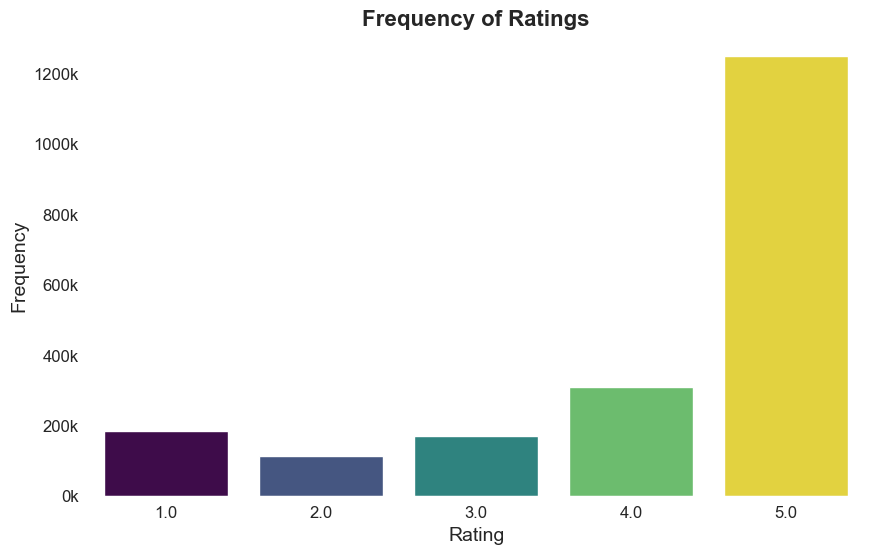

In [7]:
# Calculate the frequency of ratings
rating_counts = amazon_ratings['Rating'].value_counts().sort_index()

# Create a DataFrame from the rating counts
rating_df = rating_counts.reset_index()
rating_df.columns = ['Rating', 'Frequency']

# Create the bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_df, x='Rating', y='Frequency', hue='Rating', dodge=False, palette='viridis', legend=False)

# Customize the chart layout and style
plt.title('Frequency of Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set background to be transparent
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

# plt.gca().yaxis.get_major_formatter().set_scientific(False)

# Adjust y-axis to display numbers in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x / 1000)}k'))


# Display the chart
plt.show()

Rating of 5.0 is the highest frequency with great amount of gap. This indicates the skewness of the data which we should be cautious of. This can be due to the naive rating not being serious about the review, i.e., you just give 5 stars because users naively give 5 stars.

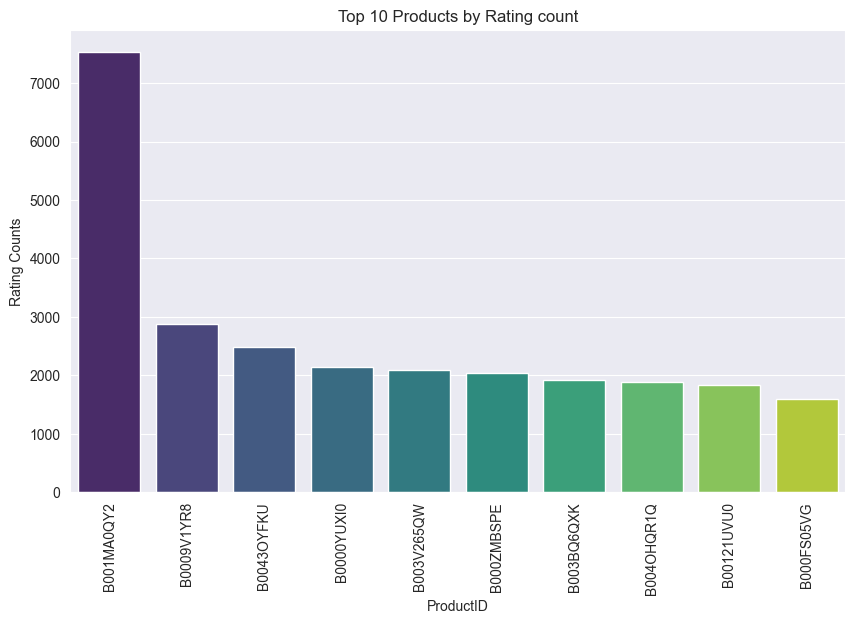

In [17]:
# Average ratings per product ID
product_rating_count = amazon_ratings.groupby('ProductId')['Rating'].count().sort_values(ascending=False)

top_10_products = product_rating_count.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_products.index, y=top_10_products.values, hue =top_10_products.index, palette='viridis', legend=False)
plt.title('Top 10 Products by Rating count')
plt.xlabel('ProductID')
plt.ylabel('Rating Counts')
plt.xticks(rotation=90)
plt.show()

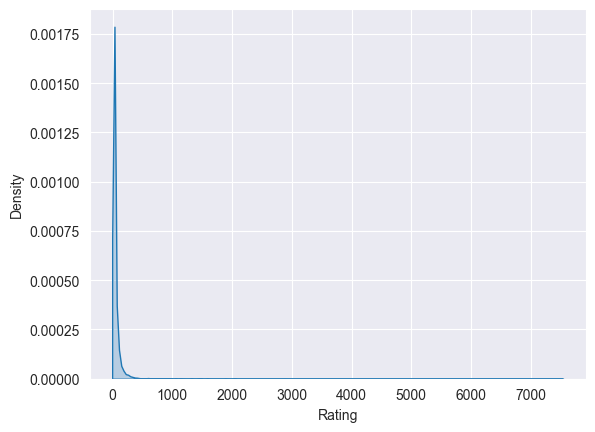

In [25]:
# Number of ratings per product KDE distribution
sns.kdeplot(product_rating_count, fill=True, cmap='viridis')
plt.show()

We can observe that one specific product has outstandingly many ratings. The product that has the most ratings has more than twice ratings than the product that has second many ratings. This also implies this rating data is skewed to specific products. From KDE plot, the number of rating is also skewed, which means most of the rating data in this dataset is from few products.